# Image Rendering

In this project, I will be implementing a program to render a 3-dimensional object using a Lambertian reflectance model. To function as an example, we will be using two albedo maps of faces. facedata.npy has been graciously provided by Professor Manhmohan Chandraker.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

# load in data provide by Manhmohan Chandraker

# Load facedata.npy as ndarray
face_data = np.load('facedata.npy',encoding='latin1', allow_pickle=True)

# Load albedo matrix 
albedo = face_data.item().get('albedo')

# Load uniform albedo matrix
uniform_albedo = face_data.item().get('uniform_albedo')

# Load heightmap 
heightmap = face_data.item().get('heightmap')
print(heightmap)

# Load light source
light_source = face_data.item().get('lightsource')
print(light_source)
print(light_source.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[120 180 300]
 [ 20  20 300]]
(2, 3)


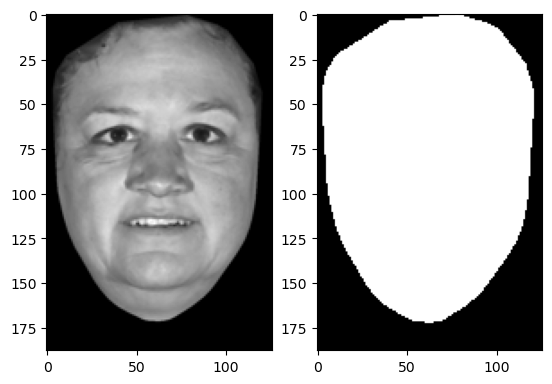

In [11]:
# Plot the face in 2-D using both Albedo Maps

f, axarr = plt.subplots(1,2)
axarr[0].imshow(albedo, cmap="gray")
axarr[1].imshow(uniform_albedo, cmap="gray")

### Plotting the face is in 3-D

Here, given both the heightmap and the albedo, we plot the face in 3-D.

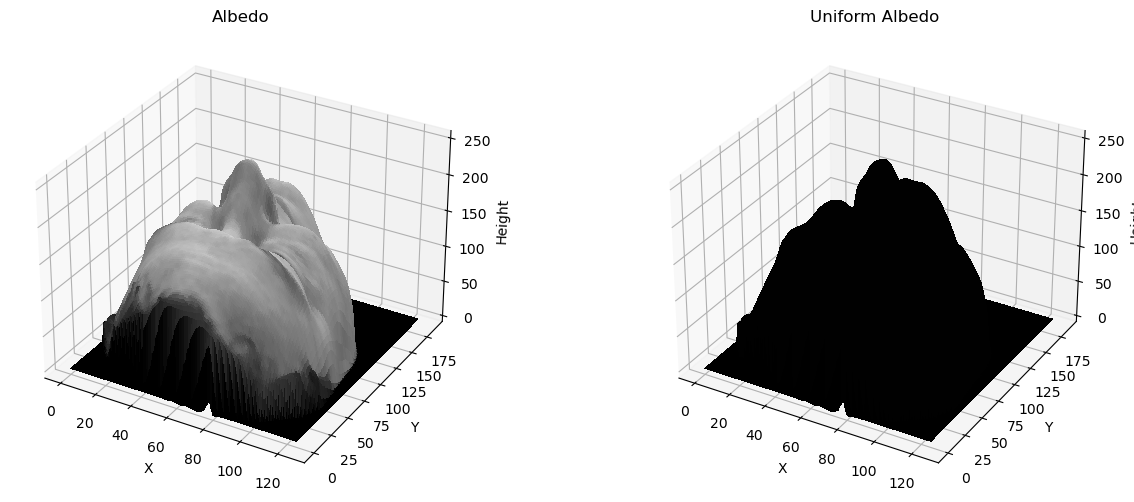

In [12]:
# Plot the face in 3-D 

# Create a grid for x and y coordinates
x, y = np.meshgrid(np.arange(heightmap.shape[0]), np.arange(heightmap.shape[1]))
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

h, w = heightmap.shape
X, Y = np.meshgrid(np.arange(w), np.arange(h))
s1 = ax1.plot_surface(X, Y, heightmap, facecolors=plt.cm.gray(albedo), rstride=1, cstride=1, cmap='gray', linewidth=0, antialiased=False)
ax1.set_title("Albedo")
s2 = ax2.plot_surface(X, Y, heightmap, facecolors=plt.cm.gray(uniform_albedo), rstride=1, cstride=1, cmap='gray', linewidth=0, antialiased=False)
ax2.set_title("Uniform Albedo")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Height')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Height')

plt.show()

### Surface normals

We calculate the surface normals and plot them using a quiver plot.

In [13]:
normals = np.stack((np.zeros(heightmap.shape),np.zeros(heightmap.shape),np.ones(heightmap.shape)), axis=-1)

import scipy.signal

filtX = np.array([
    [0,0,0],
    [1,0,-1],
    [0,0,0]
])

convX = scipy.signal.convolve2d(heightmap, filtX, mode = "same")
#print(convX.shape)

filtY = np.array([
    [0,1,0],
    [0,0,0],
    [0,-1,0]
])

convY = scipy.signal.convolve2d(heightmap, filtY, mode = "same")
#print(convY.shape)


# # Calculate the z component as 1
dz = np.ones_like(heightmap)
#print(dz.shape)

# # Stack the components to form the normal vectors
normals = np.stack((convX*-1, convY*-1, dz), axis=-1)
#print(normals.shape)

# # Calculate the magnitude of each normal vector and normalize
magnitude = np.linalg.norm(normals, axis=2, keepdims=True)
normals /= magnitude

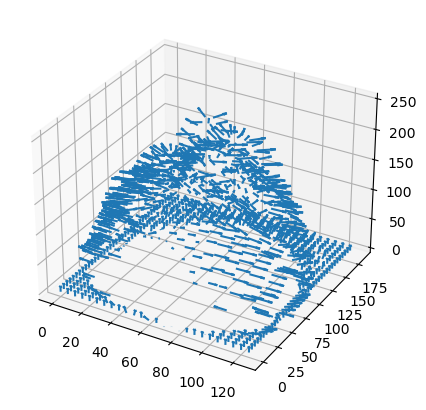

In [14]:
stride = 5
X, Y = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
                          np.arange(0,np.shape(normals)[1], stride))

Z = heightmap[::stride,::stride].T
NX = -normals[...,0][::stride,::-stride].T
NY = -normals[...,1][::-stride,::stride].T
NZ = normals[...,2][::stride,::stride].T
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
plt.quiver(Y,X,Z,NX,NY,NZ, length=10)
plt.show()

### Rendering images

We render 3 images for each of the two albedos, one for each of the two light sources, and one for both light sources pointing at the object at the same time.

In [15]:
# Render Images

def lambertian(normals, light, albedo, intensity):
    image = np.zeros(normals.shape[0:2])
    for i in range(0,len(image)):
        for j in range(0, len(image[0])):
            n_hat = normals[i,j]
            n_hat_t = np.transpose(n_hat)
            s1 = np.dot(n_hat_t, light)
            s2 = albedo[i,j]*s1*intensity
            if s2<=0:
                s2 = 0
            image[i,j] = s2
            #print(image[i,j])

    return image

In [16]:
norm_ls_0 = np.linalg.norm(light_source[0])
n_ls_0 = np.divide(light_source[0],norm_ls_0)

norm_ls_1 = np.linalg.norm(light_source[1])
n_ls_1 = np.divide(light_source[1],norm_ls_1)

Text(0.5, 1.0, 'Uni_Alb with combined LS')

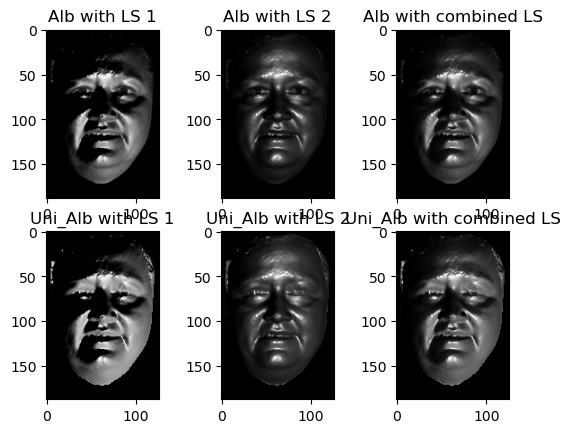

In [17]:
image1 = lambertian(normals, n_ls_0, albedo, 1)
im1Max = np.amax(image1)
im1 = np.divide(image1, im1Max)

image2 = lambertian(normals, n_ls_1, albedo, 1)
im2Max = np.amax(image2)
im2 = np.divide(image2, im2Max)

image3 = image1 + image2
im3Max = np.amax(image3)
im3 = np.divide(image3, im3Max)

image4 = lambertian(normals, n_ls_0, uniform_albedo, 1)
im4Max = np.amax(image4)
im4 = np.divide(image4, im4Max)

image5 = lambertian(normals, n_ls_1, uniform_albedo, 1)
im5Max = np.amax(image5)
im5 = np.divide(image5, im5Max)

image6 = image4 + image5
im6Max = np.amax(image6)
im6 = np.divide(image6, im6Max)

f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(im1, cmap="gray")
axarr[0,0].set_title("Alb with LS 1")

axarr[0,1].imshow(im2, cmap="gray")
axarr[0,1].set_title("Alb with LS 2")

axarr[0,2].imshow(im3, cmap="gray")
axarr[0,2].set_title("Alb with combined LS")

axarr[1,0].imshow(im4, cmap="gray")
axarr[1,0].set_title("Uni_Alb with LS 1")

axarr[1,1].imshow(im5, cmap="gray")
axarr[1,1].set_title("Uni_Alb with LS 2")

axarr[1,2].imshow(im6, cmap="gray")
axarr[1,2].set_title("Uni_Alb with combined LS")